In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
import keras
import imutils
import pytesseract

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path='../data/project/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [4]:
label_dict

{'angry': 0, 'smile': 1}

In [5]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

In [6]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [7]:
data=np.load('data.npy')
target=np.load('target.npy')

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop
from sklearn.model_selection import train_test_split

In [9]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

In [11]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [12]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name="conv2d_1"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))

    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_2"))
    model.add(Dropout(0.25, name="dropout_2"))

    model.add(Conv2D(128, (3, 3), activation='relu', name="conv2d_3"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"))
    model.add(Dropout(0.25, name="dropout_3"))

    model.add(Flatten(name="flatten"))
    model.add(Dense(512, activation='relu', name="dense_1"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2_rate, name="dropout_4"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [13]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [14]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [15]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Epoch 1/10
119/119 [==============================] - 4s 10ms/step - loss: 2.0105 - accuracy: 0.5711
Epoch 2/10
119/119 [==============================] - 1s 10ms/step - loss: 0.9927 - accuracy: 0.7103
Epoch 3/10
119/119 [==============================] - 1s 9ms/step - loss: 1.1182 - accuracy: 0.6917
Epoch 4/10
119/119 [==============================] - 1s 9ms/step - loss: 1.0587 - accuracy: 0.6148
Epoch 5/10
119/119 [==============================] - 1s 9ms/step - loss: 0.9240 - accuracy: 0.6925
Epoch 6/10
119/119 [==============================] - 1s 9ms/step - loss: 0.8481 - accuracy: 0.6976
Epoch 7/10
119/119 [==============================] - 1s 9ms/step - loss: 0.7328 - accuracy: 0.7435
Epoch 8/10
119/119 [==============================] - 1s 9ms/step - loss: 0.6126 - accuracy: 0.7630
Epoch 9/10
119/119 [==============================] - 1s 9ms/step - loss: 0.5638 - accuracy: 0.786

119/119 [==============================] - 3s 12ms/step - loss: 1.7366 - accuracy: 0.6427
Epoch 2/10
119/119 [==============================] - 1s 11ms/step - loss: 1.0428 - accuracy: 0.6900
Epoch 3/10
119/119 [==============================] - 1s 11ms/step - loss: 0.9072 - accuracy: 0.7240
Epoch 4/10
119/119 [==============================] - 1s 11ms/step - loss: 0.8240 - accuracy: 0.7242
Epoch 5/10
119/119 [==============================] - 1s 11ms/step - loss: 1.1368 - accuracy: 0.6950
Epoch 6/10
119/119 [==============================] - 1s 11ms/step - loss: 0.7951 - accuracy: 0.7543
Epoch 7/10
119/119 [==============================] - 1s 12ms/step - loss: 0.4867 - accuracy: 0.8289 0s - loss: 0.4841 - accuracy: 0.82
Epoch 8/10
119/119 [==============================] - 1s 11ms/step - loss: 0.6491 - accuracy: 0.7849
Epoch 9/10
119/119 [==============================] - 1s 12ms/step - loss: 0.6013 - accuracy: 0.8296 0s - los
Epoch 10/10
119/119 [==============================] - 1s 

In [16]:
print(optimizer.max)

{'target': 0.8823529481887817, 'params': {'dropout2_rate': 0.15866220503471082, 'lr': 0.0010448718260629255}}


In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1586))
model.add(Dense(2, activation='softmax'))

In [28]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '../data/capture1/{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

In [29]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=100, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

Epoch 1/100
15/15 [==============================] - 2s 55ms/step - loss: 0.9752 - accuracy: 0.6889 - val_loss: 1.9878 - val_accuracy: 0.6134
Epoch 2/100
15/15 [==============================] - 1s 42ms/step - loss: 0.8561 - accuracy: 0.6867 - val_loss: 4.6576 - val_accuracy: 0.5714
Epoch 3/100
15/15 [==============================] - 1s 40ms/step - loss: 0.6379 - accuracy: 0.7392 - val_loss: 1.1211 - val_accuracy: 0.6807
Epoch 4/100
15/15 [==============================] - 1s 40ms/step - loss: 0.5537 - accuracy: 0.7768 - val_loss: 0.7186 - val_accuracy: 0.7563
INFO:tensorflow:Assets written to: ../data/capture1\004-0.7186.model\assets
Epoch 5/100
15/15 [==============================] - 1s 38ms/step - loss: 0.4989 - accuracy: 0.7785 - val_loss: 1.9183 - val_accuracy: 0.6050
Epoch 6/100
15/15 [==============================] - 1s 40ms/step - loss: 0.5264 - accuracy: 0.7546 - val_loss: 3.1584 - val_accuracy: 0.5630
Epoch 7/100
15/15 [==============================] - 1s 40ms/step - loss

In [30]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_80 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_81 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)      

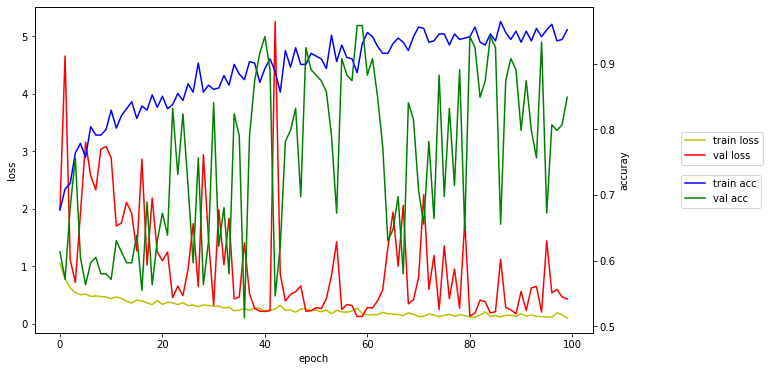

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()

In [33]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import tensorflow as tf
import keras
import imutils
import pytesseract
from keras.models import load_model
import datetime
from twilio.rest import Client

import matplotlib.pyplot as plt
%matplotlib inline

labels_dict={1:'smile', 0:'angry'}
color_dict={0:(0,255,0),1:(0,0,255)}

source=cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
record = False

face_clsfr=cv2.CascadeClassifier('../data/haarcascade_frontalface_default.xml')

model = load_model('../data/capture1/059-0.1275.model')

account_sid = 'AC7e57c5ec5bd919e4a5d4713fbde1f869'
auth_token = 'eb0719b2275be95051faf631e77c892b'

while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'angry'):
            print("좀 더 활짝 웃어봐요....")
        else:
            #cv2.imwrite("../data/capture1/" + str(now) + ".png", img)
#            client = Client(account_sid, auth_token)
#            message = client.messages.create(
#                        to="+821024173219", 
#                        from_="+19097363528",
#                       media_url=['https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile26.uf.tistory.com%2Fimage%2F99716C3F5B87BE40312542'],
#                        body="마스크 쓰세요")
            print("웃었다!!! / capture or send SMS")   
        
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),            
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
        
        
    now = datetime.datetime.now().strftime("%d_%H-%M-%S")
    key = cv2.waitKey(33)
    
    cv2.imshow('LIVE',img)
    
    if key == 27: # ESC
        #os.startfile("C:/Users/A/Anaconda3/DataScience/data/capture/output.avi")
        print("종료")
        break   
    elif key == 99: # C
        print("캡쳐")
        cv2.imwrite("../data/capture1/" + str(now) + ".png", img)
    elif key == 115: # S
        print("녹화 시작")
        record = True
        out = cv2.VideoWriter("../data/capture1/output.avi", fourcc, 20, (640, 480))
    elif key == 122: # Z
        print("녹화 중지")
        record = False
        out.release()
        
    if record == True:
        out.write(img)

source.release()

cv2.destroyAllWindows()

좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요

웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요.

웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
웃었다!!! / capture or send SMS
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
좀 더 활짝 웃어봐요....
웃었다!!! / ca